## Imports Section: Importing Necessary Packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM , Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# # Import CNN Notebook
# import import_ipynb
# import CNN_Model.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4027 non-null   datetime64[ns]
 1   Open       4027 non-null   float64       
 2   High       4027 non-null   float64       
 3   Low        4027 non-null   float64       
 4   Close      4027 non-null   float64       
 5   Adj Close  4027 non-null   flo

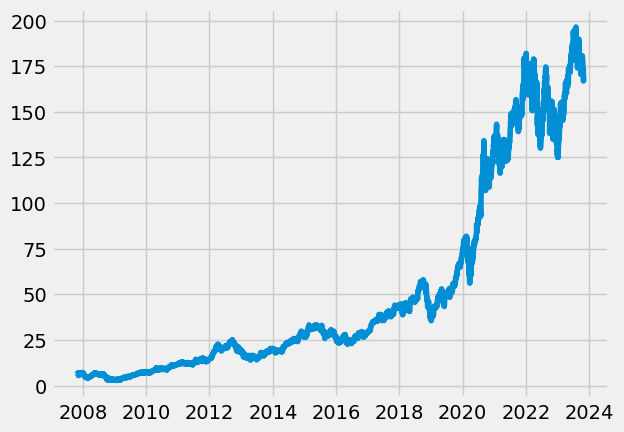

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 6.4799e-04 - loss: 0.0031 - val_accuracy: 0.0013 - val_loss: 0.0027
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 4.2746e-04 - loss: 3.9480e-04 - val_accuracy: 0.0013 - val_loss: 0.0022
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.5509e-04 - loss: 2.2055e-04 - val_accuracy: 0.0013 - val_loss: 0.0014
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 2.5471e-05 - loss: 3.0885e-04 - val_accuracy: 0.0013 - val_loss: 0.0012
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 5.6785e-05 - loss: 2.4364e-04 - val_accuracy: 0.0013 - val_loss: 0.0012
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.4304e-04 - loss: 2.0087e-04 - val_accuracy: 0.0013 - val_loss: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 2.6942e-04 - loss: 2.0529e-04 - val_accuracy: 0.0013 - val_loss: 0.0012
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 

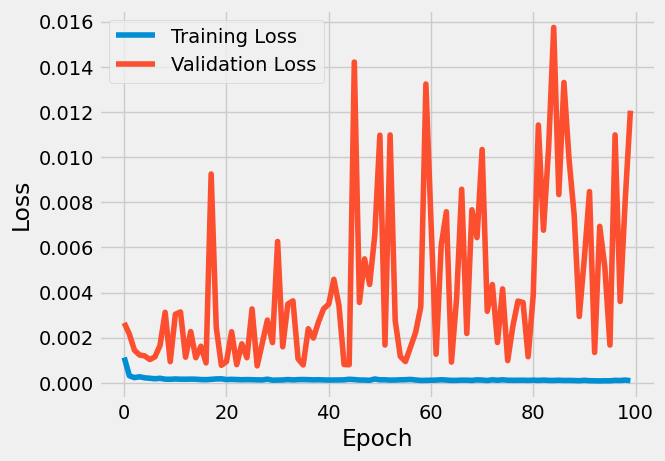

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          76,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,473 (904.20 KB)

 Trainable params: 77,157 (301.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,316 (602.80 KB)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training R2 Score: 0.9901854317870392
Training Mean Squared Error: 0.00010648693010065324
Testing R2 Score: -0.04889784822231058
Testing Mean Squared Error: 0.012061161116274937


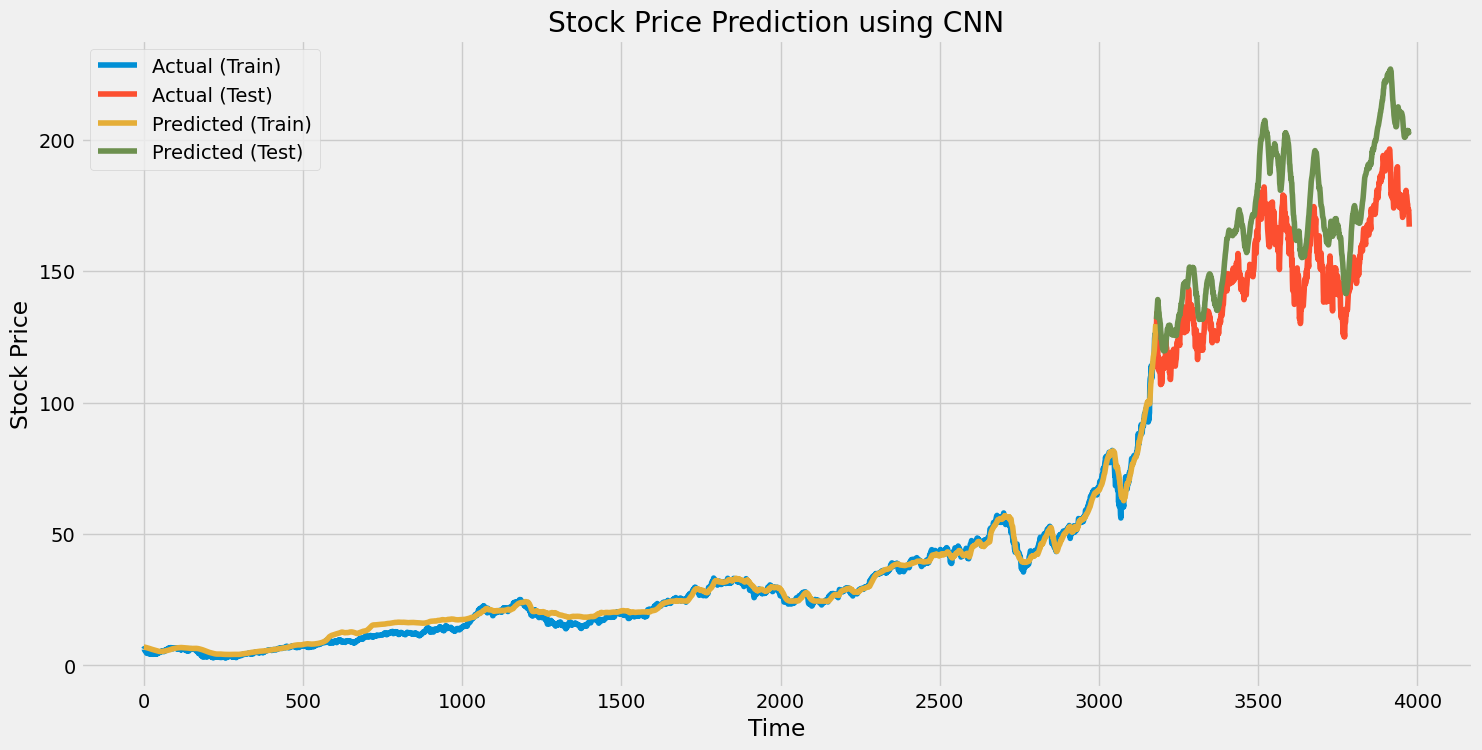

In [2]:
%run notebooks/CNN_Model.ipynb

## Ignore Warning.

In [3]:
import warnings
    
warnings.filterwarnings("ignore")

## DataFrame Reading Section: Reading DataFrames and display it.

In [4]:
# Load the dataset
df = pd.read_csv("data/AAPL_use.csv")
print(df['Close'].shape)

(4027,)


In [5]:
# Removing %h-%m-%s From Date Column
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
print(df)

            Date        Open        High         Low       Close   Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571    5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929    5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286    5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643    5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286    5.643891   
...          ...         ...         ...         ...         ...         ...   
4022  23-10-2023  170.910004  174.009995  169.929993  173.000000  173.000000   
4023  24-10-2023  173.050003  173.669998  171.449997  173.440002  173.440002   
4024  25-10-2023  171.880005  173.059998  170.649994  171.100006  171.100006   
4025  26-10-2023  170.369995  171.380005  165.669998  166.889999  166.889999   
4026  27-10-2023  166.910004  168.960007  166.830002  168.220001  168.220001   

          Volume  
0      939414000  
1

In [6]:
# Checking The Type Of Data Column(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB


In [7]:
# Converting Object To Datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

## Plotting Date and Close Price.

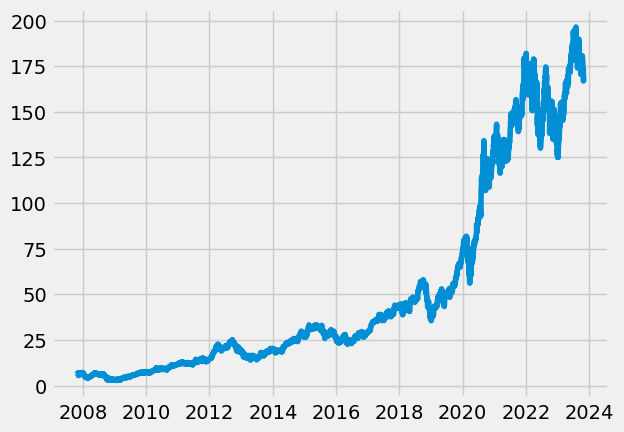

In [8]:
plt.plot(df['Date'],df['Close'])

In [9]:
print(df.shape)

(4027, 7)


## create a new dataframe with only the Close column.

In [10]:
data = df['Close'].values.reshape(-1, 1) # (rows , Columns)
print(data)

[[  6.678571]
 [  6.783929]
 [  6.694286]
 ...
 [171.100006]
 [166.889999]
 [168.220001]]


In [11]:
print(data.shape)

(4027, 1)


## Normalize the data.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)
print(data_normalized)

[[0.02006491]
 [0.02060896]
 [0.02014606]
 ...
 [0.8690986 ]
 [0.84735911]
 [0.85422693]]


## Data Preparation: Converting an Array of Values into a Dataset Matrix.

In [13]:
def prepare_data(data, time_steps):
    """
    Prepare the data for sequence modeling by converting an array of values into a dataset matrix.

    Parameters:
    - data: The input data as a numpy array.
    - time_steps: The number of time steps to consider for each sample.

    Returns:
    - X: The input features matrix.
    - y: The target variable vector.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        """Extract a sequence of data points of length 'time_steps' as input features (X)."""
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
        if i <= 1:
            """Print the first few samples of X and y for debugging purposes."""
            print("X:", X)
            print("y:", y)
            print()
    return np.array(X), np.array(y)

time_steps = 10  
X, y = prepare_data(data_normalized, time_steps)

X: [array([0.02006491, 0.02060896, 0.02014606, 0.02022536, 0.01991369,
       0.02094829, 0.01993582, 0.01793855, 0.01607591, 0.01393479])]
y: [0.01692239697436408]

X: [array([0.02006491, 0.02060896, 0.02014606, 0.02022536, 0.01991369,
       0.02094829, 0.01993582, 0.01793855, 0.01607591, 0.01393479]), array([0.02060896, 0.02014606, 0.02022536, 0.01991369, 0.02094829,
       0.01993582, 0.01793855, 0.01607591, 0.01393479, 0.0169224 ])]
y: [0.01692239697436408, 0.016212379259551185]



In [14]:
X.shape

(4017, 10)

## Reshape the data.

In [15]:
X = np.reshape(X, (X.shape[0], X.shape[1] , 1))  
print(X.shape)

(4017, 10, 1)


In [16]:
print("X: ", X)

X:  [[[0.02006491]
  [0.02060896]
  [0.02014606]
  ...
  [0.01793855]
  [0.01607591]
  [0.01393479]]

 [[0.02060896]
  [0.02014606]
  [0.02022536]
  ...
  [0.01607591]
  [0.01393479]
  [0.0169224 ]]

 [[0.02014606]
  [0.02022536]
  [0.01991369]
  ...
  [0.01393479]
  [0.0169224 ]
  [0.01621238]]

 ...

 [[0.91402334]
  [0.91872239]
  [0.90911778]
  ...
  [0.8782901 ]
  [0.87890972]
  [0.88118179]]

 [[0.91872239]
  [0.90911778]
  [0.90844646]
  ...
  [0.87890972]
  [0.88118179]
  [0.8690986 ]]

 [[0.90911778]
  [0.90844646]
  [0.90033932]
  ...
  [0.88118179]
  [0.8690986 ]
  [0.84735911]]]


In [17]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)

3213

In [18]:
input_shape=(X.shape[1],1)
print(input_shape)  

(10, 1)


## Define the LSTM model.

In [19]:
model = Sequential()
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(time_steps, 1))) # first layer
model.add(LSTM(units=64, activation='softmax'))  # Second layer
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

## Train the model.

In [20]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
26/26 - 8s - 319ms/step - loss: 0.1246 - val_loss: 0.1102
Epoch 2/50
26/26 - 1s - 35ms/step - loss: 0.0940 - val_loss: 0.0828
Epoch 3/50
26/26 - 1s - 37ms/step - loss: 0.0726 - val_loss: 0.0493
Epoch 4/50
26/26 - 1s - 37ms/step - loss: 0.0295 - val_loss: 0.0213
Epoch 5/50
26/26 - 1s - 37ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 6/50
26/26 - 1s - 37ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 7/50
26/26 - 1s - 37ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 8/50
26/26 - 1s - 36ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 9/50
26/26 - 1s - 36ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 10/50
26/26 - 1s - 32ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 11/50
26/26 - 1s - 32ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 12/50
26/26 - 1s - 35ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 13/50
26/26 - 1s - 36ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 14/50
26/26 - 1s - 36ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 15/50
26/26 - 1s - 36ms/step - loss:

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

## Compile the model.

In [22]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

In [23]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
# Train model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 7.8275e-05 - loss: 4.8926e-04 - val_accuracy: 0.0012 - val_loss: 2.6259e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0014 - loss: 2.6135e-04 - val_accuracy: 0.0012 - val_loss: 2.3247e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.6348e-04 - loss: 3.2808e-04 - val_accuracy: 0.0012 - val_loss: 2.1207e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 7.0947e-05 - loss: 2.9556e-04 - val_accuracy: 0.0012 - val_loss: 2.5982e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 3.6766e-05 - loss: 3.2467e-04 - val_accuracy: 0.0012 - val_loss: 2.0973e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 3.6683e-04 - loss: 2.3721e-04 - val_accuracy: 0.0012 - val_loss: 1.9985e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.2645e-04 - loss: 2.3236e-04 - val_accuracy: 0.0012 - val_loss: 2.0071e-04
Epoch 8/100
51/51 ━━━━━━

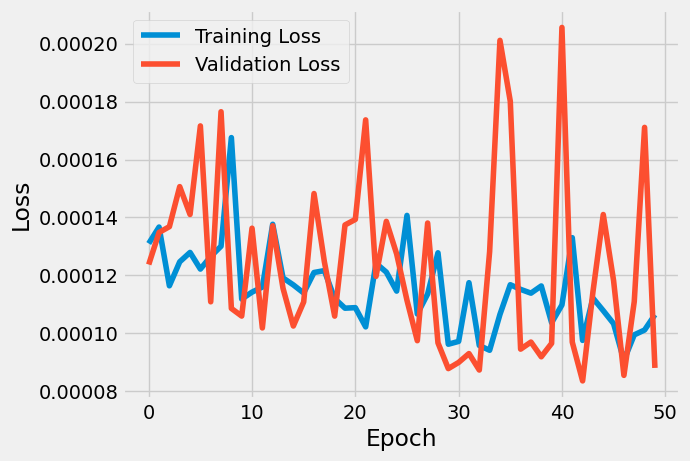

In [45]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Train the model.

In [26]:
history = model.fit(X_train, y_train, batch_size=64 , epochs=50,validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
51/51 - 2s - 39ms/step - accuracy: 3.1124e-04 - loss: 1.3101e-04 - val_accuracy: 0.0012 - val_loss: 1.2376e-04
Epoch 2/50
51/51 - 2s - 31ms/step - accuracy: 3.1124e-04 - loss: 1.3670e-04 - val_accuracy: 0.0012 - val_loss: 1.3483e-04
Epoch 3/50
51/51 - 2s - 37ms/step - accuracy: 3.1124e-04 - loss: 1.1641e-04 - val_accuracy: 0.0012 - val_loss: 1.3683e-04
Epoch 4/50
51/51 - 2s - 34ms/step - accuracy: 3.1124e-04 - loss: 1.2469e-04 - val_accuracy: 0.0012 - val_loss: 1.5065e-04
Epoch 5/50
51/51 - 1s - 28ms/step - accuracy: 3.1124e-04 - loss: 1.2794e-04 - val_accuracy: 0.0012 - val_loss: 1.4104e-04
Epoch 6/50
51/51 - 1s - 28ms/step - accuracy: 3.1124e-04 - loss: 1.2219e-04 - val_accuracy: 0.0012 - val_loss: 1.7162e-04
Epoch 7/50
51/51 - 2s - 36ms/step - accuracy: 3.1124e-04 - loss: 1.2654e-04 - val_accuracy: 0.0012 - val_loss: 1.1089e-04
Epoch 8/50
51/51 - 1s - 29ms/step - accuracy: 3.1124e-04 - loss: 1.3008e-04 - val_accuracy: 0.0012 - val_loss: 1.7652e-04
Epoch 9/50
51/51 - 2s - 

## Evaluate model.

In [27]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Train Loss: [8.651709504192695e-05, 0.00031123560620471835]
Test Loss: [8.8053522631526e-05, 0.001243781065568328]


## Get the models predicted price values.

In [28]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


## Calculate R2 score and MSE for testing data.

In [29]:
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

In [30]:
# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}') 

Training R2 Score: 0.9901854317870392
Training Mean Squared Error: 0.00010648693010065324
Testing R2 Score: 0.9988673969441827
Testing Mean Squared Error: 8.805352052392932e-05


## Plotting predictions.

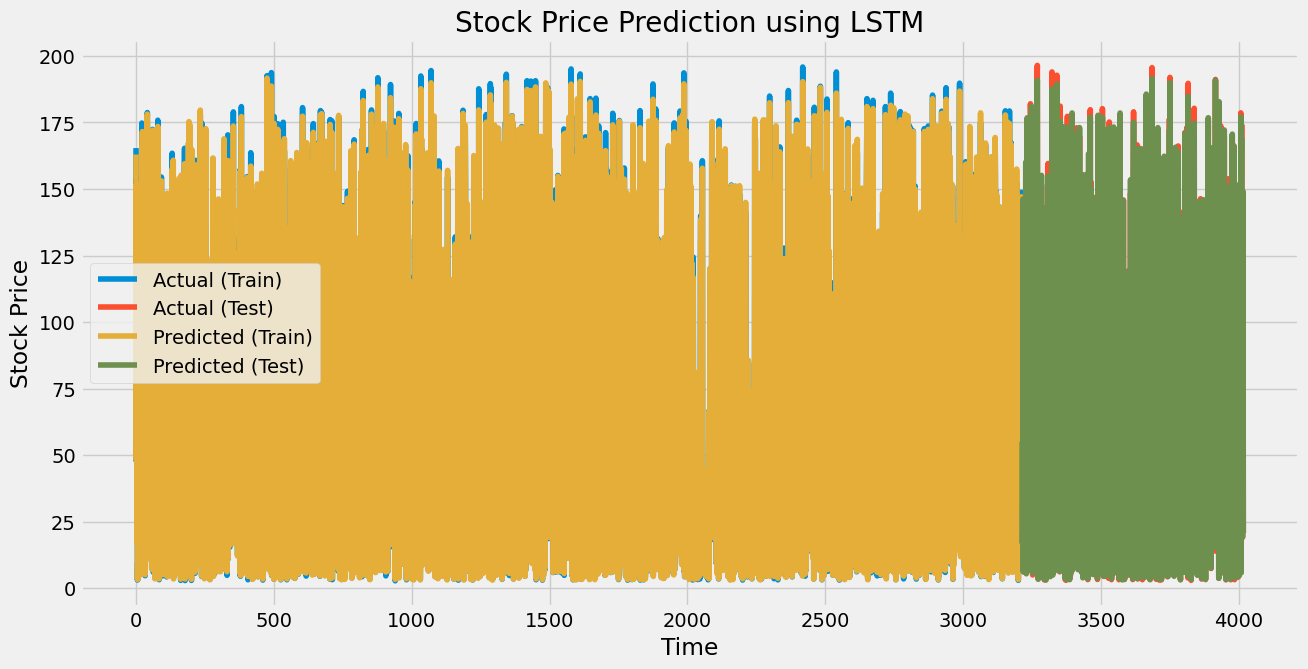

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [32]:
scaler.inverse_transform(y_train.reshape(-1, 1))
len(y_train) + len(y_test)

4017

## Plotting training history.

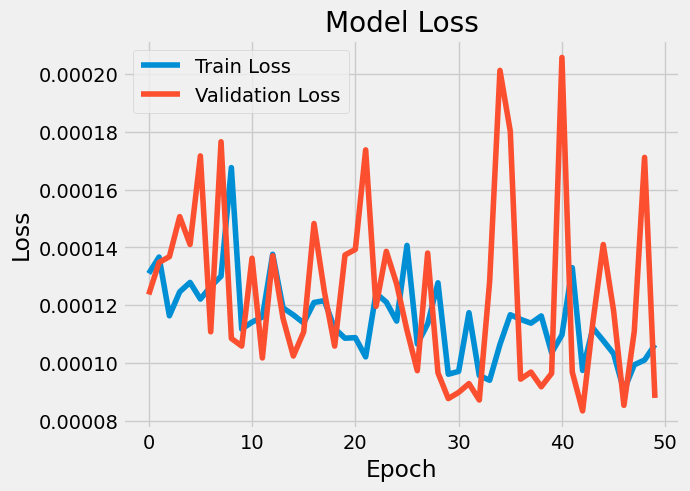

In [44]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make predictions.

In [34]:
y_pred = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## Inverse transform the predictions and actual values.

In [35]:
y_pred = scaler.inverse_transform(y_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [36]:
# Calculate R2 score
r2 = r2_score(y_test_orig, y_pred)
print("R2 Score:", r2)

R2 Score: 0.9988673971418133


In [37]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_orig, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.302278341511681


## Plotting the actual vs. predicted values.

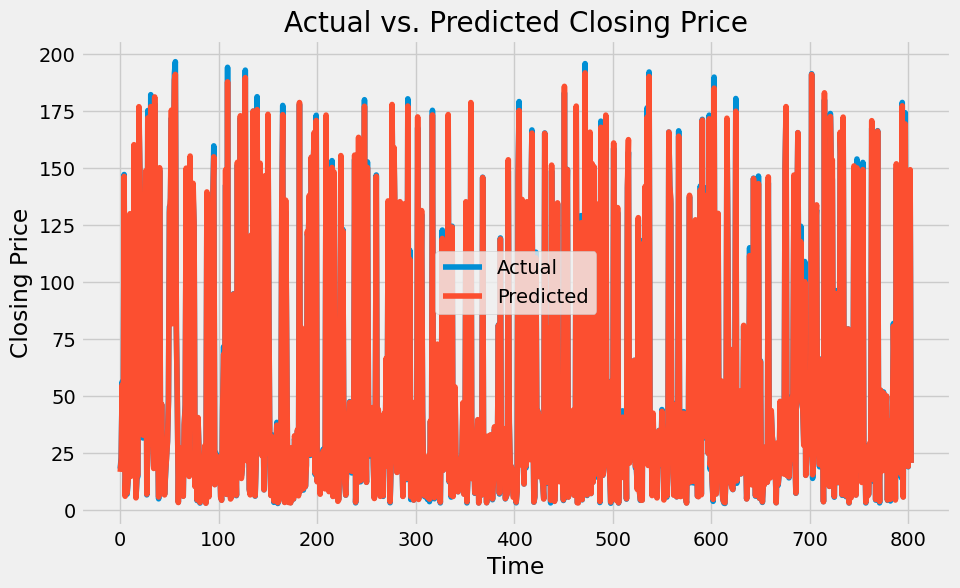

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Plot actual vs predicted closing prices.

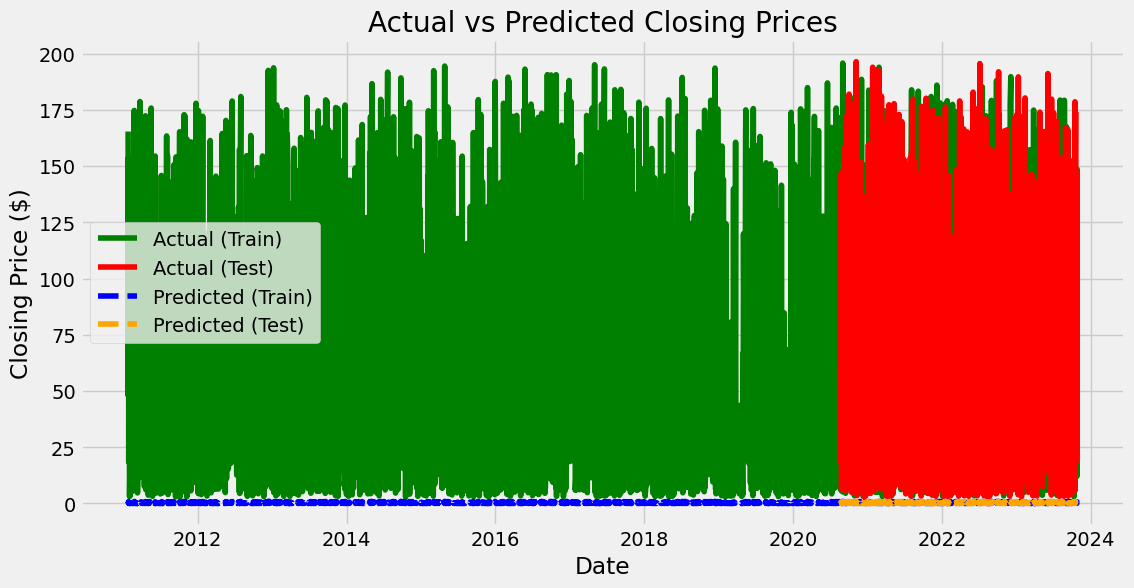

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_train_orig):], y_train_orig, label='Actual (Train)', color='green')
plt.plot(df['Date'][-len(y_test_orig):], y_test_orig, label='Actual (Test)', color='red')
plt.plot(df['Date'][-len(train_predictions):], train_predictions, label='Predicted (Train)', linestyle='--', color='blue')
plt.plot(df['Date'][-len(test_predictions):], test_predictions, label='Predicted (Test)', linestyle='--', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## Create a plot comparing actual, predicted, and closing prices.

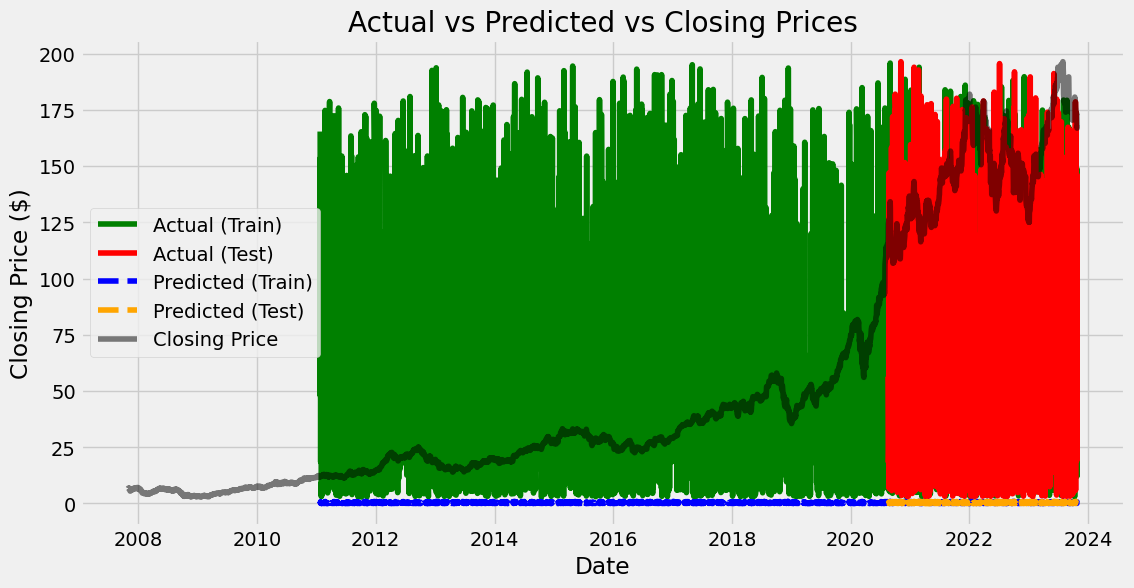

In [48]:
plt.figure(figsize=(12, 6))

# Plot actual closing prices
plt.plot(df['Date'][-len(y_train_orig):], y_train_orig, label='Actual (Train)', color='green')
plt.plot(df['Date'][-len(y_test_orig):], y_test_orig, label='Actual (Test)', color='red')

# Plot predicted closing prices
plt.plot(df['Date'][-len(train_predictions):], train_predictions, label='Predicted (Train)', linestyle='--', color='blue')
plt.plot(df['Date'][-len(test_predictions):], test_predictions, label='Predicted (Test)', linestyle='--', color='orange')

# Plot closing prices
plt.plot(df['Date'], df['Close'], label='Closing Price', color='black', alpha=0.5)

plt.title('Actual vs Predicted vs Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()


## Comparison: Plotting the Actual vs. Predicted Values using CNN vs LSTM.

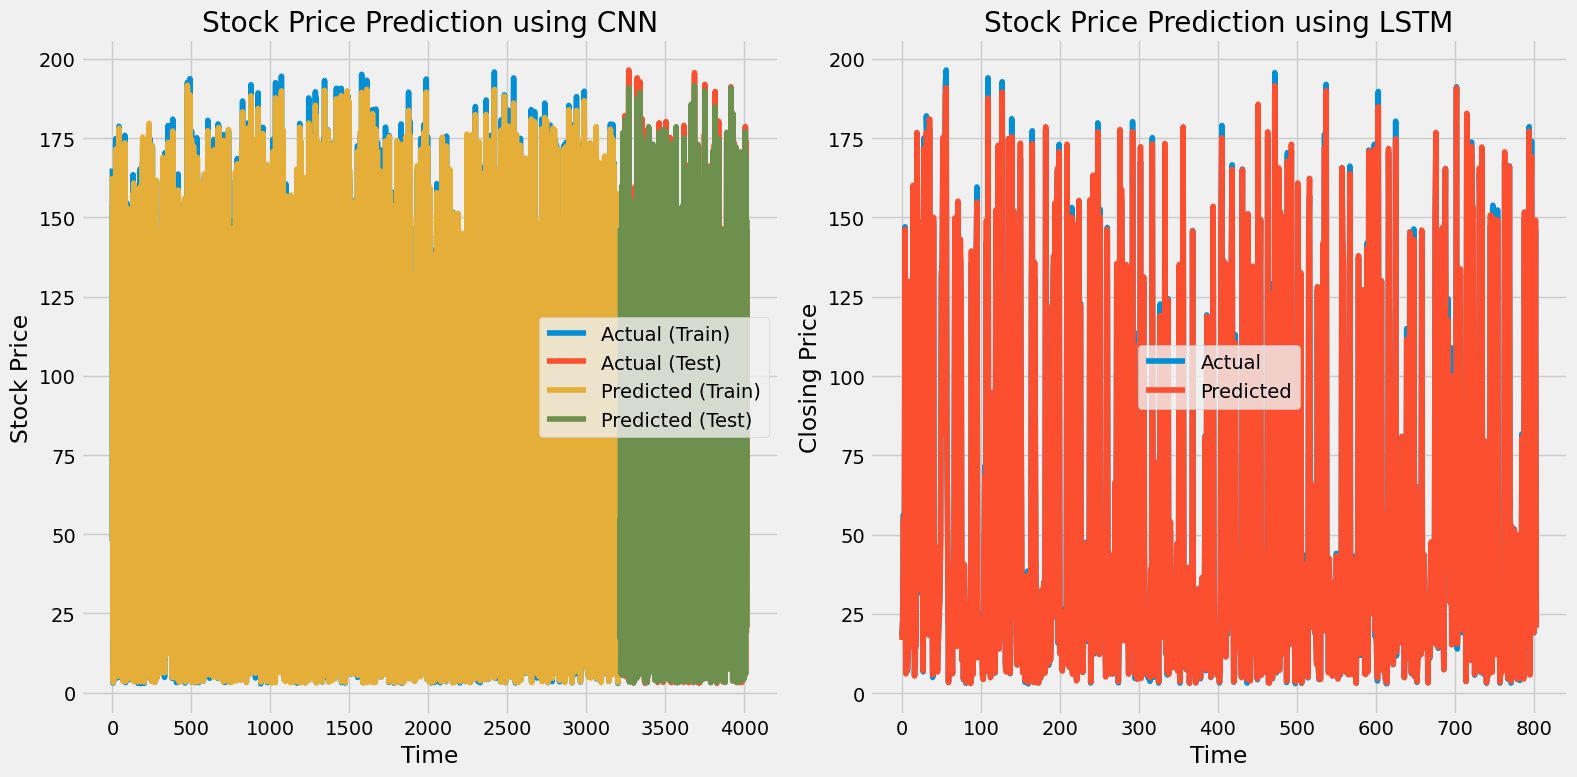

In [50]:
plt.figure(figsize=(16, 8))

# Plot predictions using CNN
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot predictions using the other method
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()
